<a href="https://colab.research.google.com/github/yashwanthannem/Hackathons/blob/master/Novartis_DS_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Necessary Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,precision_recall_curve
%matplotlib inline

Install smote-variants package which is needed for upsampling as the classes are imbalanced

In [ ]:
!pip install smote-variants


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading the dataset

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/datahack/Novartis_DS/Train.csv")
test_df = pd.read_csv("/content/drive/My Drive/datahack/Novartis_DS/Test.csv")
submission_df = pd.read_csv("/content/drive/My Drive/datahack/Novartis_DS/sample_submission.csv")

Converting to datetime

In [ ]:
#date column preprocessing
train_df['DATE'] = pd.to_datetime(train_df['DATE'])
test_df['DATE'] = pd.to_datetime(test_df['DATE'])

In [ ]:
#creating new features MONTH,YEAR,DAY,weekday,IsWeekend columns out of data column for train
train_df['MONTH'] = train_df['DATE'].dt.month
train_df['YEAR'] = train_df['DATE'].dt.year
train_df['DAY'] = train_df['DATE'].dt.day
train_df['weekday'] = train_df['DATE'].dt.dayofweek
train_df['IsWeekend'] = train_df['weekday'].apply(lambda x : 1 if ((x==6) or (x==5)) else 0)

In [ ]:
#creating new features MONTH,YEAR,DAY,weekday,IsWeekend columns out of data column for test
test_df['MONTH'] = test_df['DATE'].dt.month
test_df['YEAR'] = test_df['DATE'].dt.year
test_df['DAY'] = test_df['DATE'].dt.day
test_df['weekday'] = test_df['DATE'].dt.dayofweek
test_df['IsWeekend'] = test_df['weekday'].apply(lambda x : 1 if ((x==6) or (x==5)) else 0)

From below set of box plot for all columns starting with X_ against target and below are the inferences
1.   X_11,X_12,X_10,X_15 seems to help in the prediction of the target variable



The `size` parameter has been renamed to `height`; please update your code.


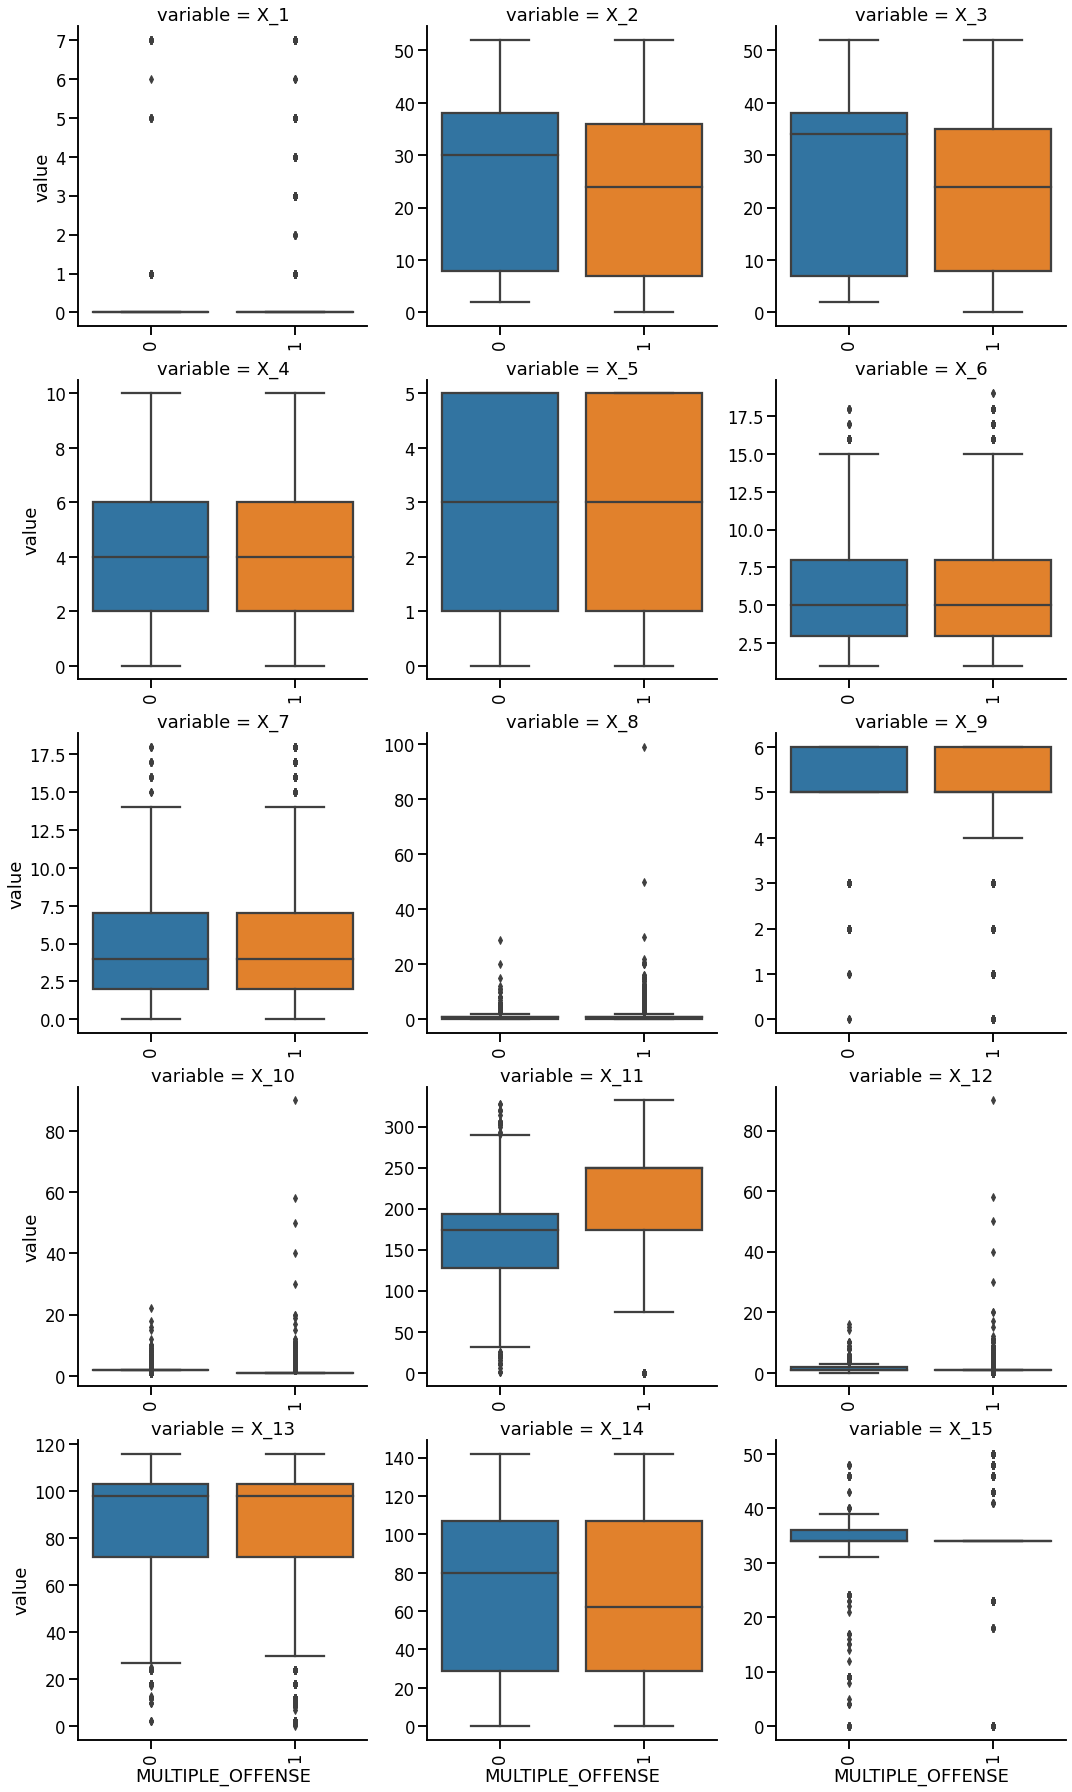

In [ ]:
"""
creating box plot for all the columns starting with X_ against target MULTIPLE_OFFENSE column
-MULTIPLE_OFFENSE on X axis     
-value of particular column on Y-axis
"""
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

x_feat =[x for x in train_df.columns if x.startswith('X_')]
p = pd.melt(train_df, id_vars='MULTIPLE_OFFENSE', value_vars=x_feat)
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'MULTIPLE_OFFENSE','value')
g

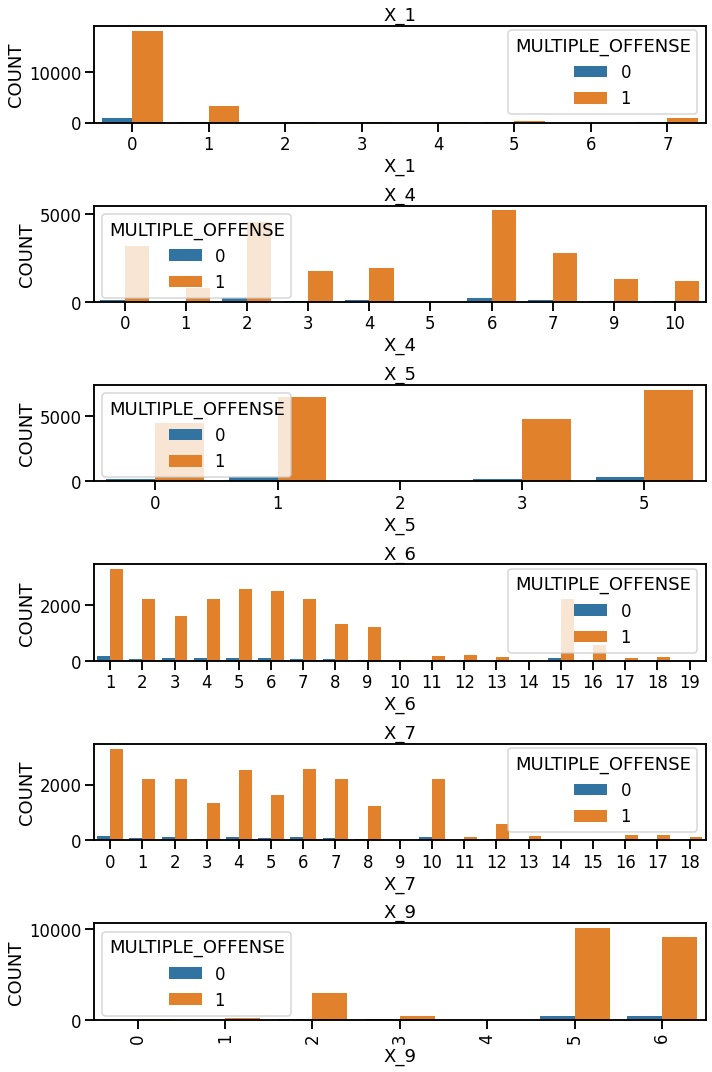

In [ ]:
"""
creating count plot for all the columns 'X_1','X_4','X_5','X_6','X_7','X_9' against count of target MULTIPLE_OFFENSE column
-Unique values on X axis     
-Count of each MULTIPLE_OFFENSE value
-Legend MULTIPLE_OFFENSE
"""
cat_colums = ['X_1','X_4','X_5','X_6','X_7','X_9']
fig, axes =plt.subplots(len(cat_colums),1)
for t,i in enumerate(cat_colums):
  #print(i,t)
  sns.barplot(x=i,y='COUNT',hue='MULTIPLE_OFFENSE',data=train_df.groupby([i])['MULTIPLE_OFFENSE'].value_counts().to_frame().rename(columns={'MULTIPLE_OFFENSE':'COUNT'}).reset_index(),ax=axes[t])
  axes[t].figure.set_size_inches(10, 15)
  axes[t].set_title(i)
  plt.xticks(rotation=90)
  plt.tight_layout()

In [ ]:
#finding the correlation among the features and find the ones whose value is greater than 0.8
# Calculate the correlation values
feature_cols = [x for x in train_df.columns if x != 'MULTIPLE_OFFENSE']
corr_values = train_df[feature_cols].corr()
tril_index = np.tril_indices_from(corr_values)
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))
corr_values['abs_correlation'] = corr_values.correlation.abs()

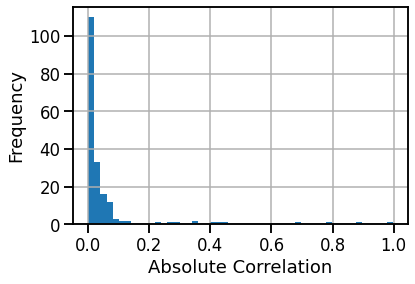

In [ ]:
ax = corr_values.abs_correlation.hist(bins=50)
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [ ]:
# The most highly correlated values
# most correlated feature so we will drop the columns X_3 and X_12
#Since I used tree based models I didn't removed these features while trainign
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
19,X_2,X_3,0.996985,0.996985
136,X_10,X_12,0.877743,0.877743


Start Model Building

In [ ]:
#create oversampled data using SMOTE technique

def create_oversample_data(input_df):
  import smote_variants as sv
  oversampler= sv.SMOTE()
  feature_cols = [x for x in input_df.columns if x != 'MULTIPLE_OFFENSE']
  train_x = input_df[feature_cols]
  train_y = input_df['MULTIPLE_OFFENSE']
  #oversampling
  train_x_os, train_y_os = oversampler.sample(np.array(train_x), np.array(train_y))
  print('After OverSampling, the shape of train_X: {}'.format(train_x_os.shape))
  print('After OverSampling, the shape of train_y: {} \n'.format(train_y_os.shape))
  print("After OverSampling, counts of label '1': {}".format(sum(train_y_os==1)))
  print("After OverSampling, counts of label '0': {}".format(sum(train_y_os==0)))
  train_x_os_df = pd.DataFrame(train_x_os,columns=feature_cols)
  train_y_os_df = pd.DataFrame(train_y_os,columns=['MULTIPLE_OFFENSE'])
  input_df_os = pd.concat([train_x_os_df,train_y_os_df],axis=1)
  return input_df_os

In [ ]:
#method to create stratified split so that train and test split happens with equal distributions of target label

def create_stratified_split(data):
  from sklearn.model_selection import StratifiedShuffleSplit
  feature_cols = [x for x in data.columns if x != 'MULTIPLE_OFFENSE']
  strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
  # Get the index values from the generator
  train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['MULTIPLE_OFFENSE']))
  # Create the data sets
  X_train = data.loc[train_idx, feature_cols]
  y_train = data.loc[train_idx, 'MULTIPLE_OFFENSE']
  X_test = data.loc[test_idx, feature_cols]
  y_test = data.loc[test_idx, 'MULTIPLE_OFFENSE']
  return  X_train,y_train,X_test,y_test

XGBoost Model Building

In [ ]:
import xgboost

train_df_xg = train_df.copy()
test_df_xg = test_df.copy()

In [ ]:
train_df_xg.drop(['INCIDENT_ID','DATE','YEAR','IsWeekend','weekday','MONTH', 'DAY'],axis=1,inplace = True)
train_df_xg = create_oversample_data(train_df_xg)
train_df_xg['X_12'].fillna(999,inplace=True)
print(train_df_xg.columns)

2020-06-21 13:42:58,917:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


After OverSampling, the shape of train_X: (45576, 15)
After OverSampling, the shape of train_y: (45576,) 

After OverSampling, counts of label '1': 22788
After OverSampling, counts of label '0': 22788
Index(['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10',
       'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'MULTIPLE_OFFENSE'],
      dtype='object')


In [ ]:
#predictions for test 
test_incident_id_values = test_df_xg['INCIDENT_ID']
test_df_xg['X_12'].fillna(999,inplace=True)
test_df_xg.drop(['INCIDENT_ID','DATE','YEAR','IsWeekend','weekday','MONTH', 'DAY'],axis=1,inplace = True)

In [ ]:
feature_cols = [x for x in train_df_xg.columns if x != 'MULTIPLE_OFFENSE']

In [ ]:
X_train,y_train,X_test,y_test = create_stratified_split(train_df_xg)

In [ ]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'gamma': 0.65,
    "eval_metric": "logloss",
    'num_boost_round' : 700
    }

In [ ]:
#creating 5 folds using Stratified K fold and applying XGBoost model on these folds with early stopping rounds set to 70
#Setting threshold as 0.5 as XGboost model predict givesus the probabilities
#Storing the Test data predictions to predictions dictionary which i will use
#Storing each model trained on each fold into models dictionary which I will use to plot the feature importance

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score

train_feat = train_df_xg[feature_cols]
train_lab = train_df_xg['MULTIPLE_OFFENSE']
test = test_df_xg[feature_cols]

#threshold for rounding the prediction probabilities to 1 or 0
threshold = 0.5
predictions = {}
models = {}
print("train shape before kfold",train_feat.shape)

#splitting the data into 5 folds using stratified K fold so that the labels of the target are properly balanced
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


for i,(ktrain,kvalid) in enumerate(skf.split(train_feat,train_lab)):
  print("------------------------------------------------")
  print('[Executing XGBoost model for fold %d/5]' % (i + 1))

  X_train_k,X_valid_k = train_feat.loc[ktrain],train_feat.loc[kvalid]
  y_train_k,y_valid_k = train_lab.loc[ktrain],train_lab.loc[kvalid]

  print("train shape after kfold",X_train_k.shape,y_train_k.shape)
  print("valid shape after kfold",X_valid_k.shape,y_valid_k.shape)

  d_train_k = xgboost.DMatrix(X_train_k, label=y_train_k)
  d_valid_k = xgboost.DMatrix(X_valid_k, label=y_valid_k)
  d_test_k = xgboost.DMatrix(test)

  #model on each fold with params defined above and evaluating on train and test
  model = xgboost.train(params, d_train_k, 5000, evals = [(d_train_k, "train"),(d_valid_k, "valid")], verbose_eval=400, early_stopping_rounds=70)

  #predictions on validation set of each fold
  y_valid_pred = model.predict(d_valid_k)

  #print recall score for each fold
  print("Recall_Score of XGBoost model for fold %d/5" % (i + 1),recall_score(y_valid_k, np.where(y_valid_pred > threshold,1,0)))

  #prediction on the test data for submission
  p_test = model.predict(d_test_k, ntree_limit=model.best_ntree_limit)

  #store them in a dictionary with key for each fold as Kfold<<current_fold>>""
  predictions["Kfold"+str(i)] = p_test
  
  #storing each model into dictionary 
  models["Kfold"+str(i)] = model

  print('[End of XGBoost model for fold %d/5]' % (i + 1))
  print("------------------------------------------------")


train shape before kfold (45576, 15)
------------------------------------------------
[Executing XGBoost model for fold 1/5]
train shape after kfold (36460, 15) (36460,)
valid shape after kfold (9116, 15) (9116,)
[0]	train-logloss:0.672482	valid-logloss:0.672495
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 70 rounds.
[400]	train-logloss:0.005372	valid-logloss:0.005956
[800]	train-logloss:0.003532	valid-logloss:0.004062
[1200]	train-logloss:0.003064	valid-logloss:0.003551
[1600]	train-logloss:0.00282	valid-logloss:0.003299
[2000]	train-logloss:0.002696	valid-logloss:0.003175
[2400]	train-logloss:0.002618	valid-logloss:0.003102
[2800]	train-logloss:0.00257	valid-logloss:0.00306
[3200]	train-logloss:0.002524	valid-logloss:0.003014
[3600]	train-logloss:0.0025	valid-logloss:0.002992
Stopping. Best iteration:
[3709]	train-logloss:0.002495	valid-logloss:0.002985

Recall_Score of XGBoost model for fo

In [ ]:
#Creating dataframe for prediction of each model built on 5 folds and considering the final output as 1 only if the sum is greater than or equal to 1
predictions_df = pd.DataFrame(predictions)
predictions_df['final'] = predictions_df.sum(axis=1)
predictions_df['final_pred'] = predictions_df['final'].apply(lambda x : 1 if x >=3 else 0)

In [ ]:
#building final submissions 
df_submit = pd.DataFrame({'INCIDENT_ID': test_incident_id_values, 'MULTIPLE_OFFENSE': predictions_df['final_pred']})
df_submit.to_csv("/content/drive/My Drive/datahack/Novartis_DS/xgboost_kstratfold_5.csv", index=False) #99.02 recall_score

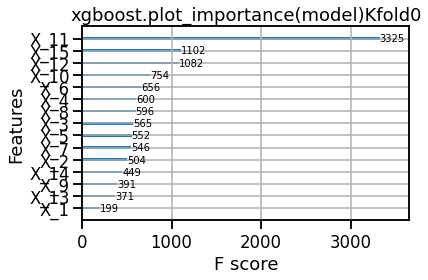

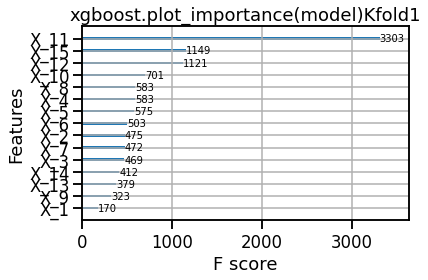

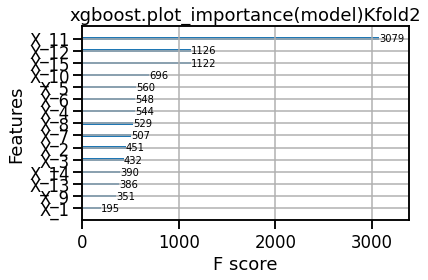

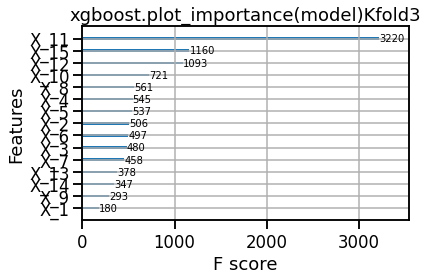

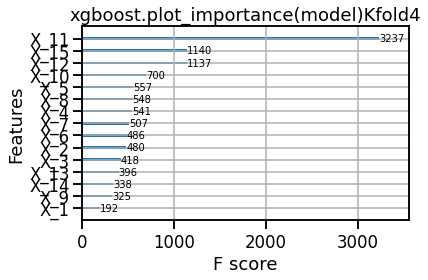

In [ ]:
#getting feature importances for each model built on 5 folds
#thought X11,X15,X12 are common for all models but there is difference in feature importance for X_3,X_5 for which the ensemble model helped in getting higher accuracy

for i,ind_model in enumerate(models):
  model = models.get(ind_model)
  xgboost.plot_importance(model)
  plt.title("xgboost.plot_importance(model)"+ind_model)
  plt.tight_layout()
  plt.show()
